In [25]:
import pandas as pd
from scipy.io import wavfile
import librosa
import numpy as np  
import os
import resampy
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

In [60]:
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [188]:
DATASET_PATH = r"C:\Users\Acer\OneDrive\Desktop\projects\Gender_voice_recogintion\gender-recognition-by-voiceoriginal\data"

# Function to extract MFCC features from audio
def extract_features(file_path, max_pad_len=174):
    try:
        audio, sample_rate = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs.flatten()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Prepare dataset
data = []
labels = []

for label in ['male', 'female']:
    folder = os.path.join(DATASET_PATH, label)
    for filename in os.listdir(folder):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder, filename)
            features = extract_features(file_path)
            if features is not None:
                data.append(features)
                labels.append(label)

# Convert to DataFrame
X = np.array(data)
y = np.array(labels)

In [189]:
X.shape

(16148, 6960)

In [190]:
len(X[0])

6960

In [191]:
pca = PCA(n_components=230)
X_pca = pca.fit_transform(X)
print(X_pca[:230])

[[-2.0500529e+02  4.8350162e+02 -4.7154361e+02 ...  1.1507813e+01
   2.9749735e+01  2.9250624e+00]
 [-3.2217621e+02  9.0751764e+02 -3.9655952e+01 ... -4.1436398e+01
   3.8117165e+01 -5.4268158e+01]
 [ 1.5850696e+03 -2.6058301e+02 -8.5413312e+02 ... -2.5169138e+01
   7.3642731e+01 -2.7939709e+01]
 ...
 [-1.2778687e+03 -2.2840569e+02  3.1085007e+02 ...  1.8051245e+01
   1.0306995e+01 -6.3375506e+00]
 [-1.1810665e+03 -8.2145103e+01  4.5568341e+02 ... -6.6378438e-01
   1.5525161e+01  3.3382427e+01]
 [-1.1247354e+03  3.0089977e+01  5.8437280e+02 ... -7.7810532e+01
   5.5724049e+01  4.2537079e+01]]


In [192]:
X_pca.shape

(16148, 230)

In [193]:
print("Explained variance:", pca.explained_variance_ratio_)
print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))

Explained variance: [0.2601117  0.08112688 0.04223496 0.02857752 0.02334304 0.02047255
 0.01797502 0.01606921 0.01438658 0.0134749  0.0126648  0.01127699
 0.01003387 0.00981004 0.00935763 0.00850494 0.00772662 0.00723174
 0.00689766 0.00661969 0.00628046 0.00612645 0.00595276 0.0057297
 0.00555089 0.00533188 0.00515277 0.00500756 0.00484885 0.00459268
 0.00452471 0.00434936 0.00418422 0.00408192 0.00393611 0.00388124
 0.00378296 0.00370651 0.00369222 0.00361691 0.00350298 0.00346706
 0.00340723 0.00335416 0.0032716  0.00322145 0.00318305 0.00306598
 0.00303825 0.00290541 0.00288816 0.0028056  0.00274979 0.00269193
 0.0026351  0.00254636 0.00252904 0.00248529 0.00241985 0.00237608
 0.00228532 0.00225374 0.00221803 0.00217954 0.00214298 0.0021088
 0.00206824 0.00201031 0.00199916 0.00190586 0.00189534 0.00186972
 0.00180547 0.00178467 0.00176995 0.00171251 0.00167121 0.00164656
 0.001616   0.00158754 0.00156048 0.0015589  0.00150568 0.00148676
 0.00145114 0.0014399  0.00138717 0.00135027

In [194]:
y_binary = np.where(y == "male", 1, 0)

In [195]:
y_binary.shape
X_pca.shape

(16148, 230)

In [196]:
unique, counts = np.unique(y, return_counts=True)

<BarContainer object of 2 artists>

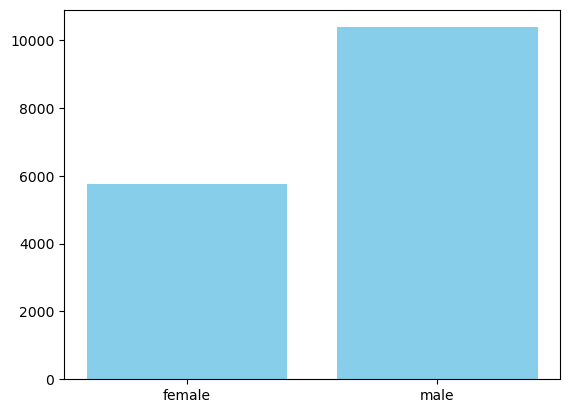

In [197]:
import matplotlib.pyplot as plt
plt.bar(unique, counts, color='skyblue')

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_binary, test_size=0.4, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=2)

In [201]:
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [202]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2251
           1       0.96      0.98      0.97      4209

    accuracy                           0.96      6460
   macro avg       0.95      0.95      0.95      6460
weighted avg       0.96      0.96      0.95      6460



In [217]:
import sounddevice as sd
from scipy.io.wavfile import write

fs = 44100  # Sampling rate
seconds = 5  # Duration of recording

print("Recording...")
recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()
write("my_voice.wav", fs, recording)
print("Recording saved as my_voice.wav")


Recording...
Recording saved as my_voice.wav


In [218]:
# Load new audio
audio, sr = librosa.load(r"C:\Users\Acer\OneDrive\Desktop\projects\Gender_voice_recogintion\my_voice.wav")

# Extract MFCC features with same config used during training
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
pad_width = 174 - mfcc.shape[1]
if pad_width > 0:
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
else:
    mfcc = mfcc[:, :174]

# Flatten MFCCs
z = mfcc.flatten().reshape(1, -1)  # shape: (1, 6960)

z=z.reshape(1, -1)

z.shape

(1, 6960)

In [219]:
z_pca = pca.transform(z)

In [ ]:
output=grid_search.predict(z_pca) 
if output==1:
    print("It's male voice")
else:
    print("Its female voice")


It's male voice
